# Overlay ROI from different sessions

GOAL: visualize components from session Y on the movie of session X all recorded from Mouse #??

You really need to seed the CNMF object for session Y based on the data from session X.

In [1]:
import os
import tifffile
import matplotlib.pyplot as plt
import numpy as np

from caiman.source_extraction.cnmf.cnmf import load_CNMF
from caiman.summary_images import correlation_pnr
from caiman.base.rois import register_multisession
from caiman.utils import visualization

# load local package
import sys
root_dir = os.path.split(os.getcwd())[0] # get root
utils_dir = os.path.join(root_dir,'utils') # get utils folder path
sys.path.append(utils_dir) # add it to system path (not ideal) - doing this to reduce pip installs for local lab usage
import plot_tools as fpl_tools # import movie

caiman package loaded...
Suite2p not detected...


# CaImAn multi-session registration method

`models_list` a list of directories containing your .hdf5 file to compare

`movies_list` are the corresponding movies based on the naming conventions of `models_list`, created from VizResults_miniscope

`images_list` list of imaging data from the various movies that is the same `len` as there are models_list inputs

`cnmf_list` a list of cnmf objects loaded from the `models_list` variable

In [2]:
# enter manually
models_list = [r'/Users/js0403/miniscope/PFC-Neurons/122D/AAV2/3-Syn-GCaMP8f/2024_03_05/12_51_33/miniscopeDeviceName/full_movie_20240320224747_cnmfe.hdf5',
               r'/Users/js0403/miniscope/PFC-Neurons/122D/AAV2/3-Syn-GCaMP8f/2024_03_15/10_57_51/miniscopeDeviceName/full_movie_20240320185923_cnmfe.hdf5',
               r'/Users/js0403/miniscope/PFC-Neurons/122D/AAV2/3-Syn-GCaMP8f/2024_03_21/15_01_43/miniscopeDeviceName/full_movie_20240322113218_cnmfe.hdf5']
cnmf_list = [load_CNMF(i) for i in models_list]

# get name of movie based on the models_list naming conventions
movies_list = []; images_list = []
for i in models_list:
    root_path,file_long = os.path.split(i)
    movie_name = os.path.join(root_path,('_').join(file_long.split('_')[0:2])+'.tif')
    movies_list.append(movie_name)
    images_list.append(tifffile.memmap(movie_name))

# get correlation object
print("Please wait while the spatial correlation matrices are being estimated...")
corr_images = []; pnr_images = []
for i in range(len(images_list)):
    corr, pnr = correlation_pnr(images_list[i][::5],gSig=cnmf_list[i].params.init['gSig'][0],swap_dim=False)
    corr_images.append(corr)
    pnr_images.append(pnr)
    print("Finished with",str(i+1),"/",str(len(images_list)))

Please wait while the spatial correlation matrices are being estimated...
Finished with 1 / 2
Finished with 2 / 2


## Use `register_multisession()`

The function `register_multisession()` requires 3 arguments:
- `A`: A list of ndarrays or scipy.sparse.csc matrices with (# pixels X # component ROIs) for each session
- `dims`: Dimensions of the FOV, needed to restore spatial components to a 2D image
- `templates`: List of ndarray matrices of size `dims`, template image of each session

In [3]:
spatial=[i.estimates.A[:,i.estimates.idx_components] for i in cnmf_list]
dims=corr_images[0].shape
templates=corr_images

spatial_union, assignments, matchings = register_multisession(A=spatial, dims=dims, templates=templates)

/Users/js0403/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [5]:
%matplotlib qt
# Filter components by number of sessions the component could be found
n_reg = 2  # minimal number of sessions that each component has to be registered in

# Use number of non-NaNs in each row to filter out components that were not registered in enough sessions
assignments_filtered = np.array(np.nan_to_num(assignments[np.sum(~np.isnan(assignments), axis=1) >= n_reg]), dtype=int);

# Use filtered indices to select the corresponding spatial components
spatial_filtered = spatial[0][:, assignments_filtered[:, 0]]

# Plot spatial components of the selected components on the template of the last session
visualization.plot_contours(spatial_filtered, templates[0]);

In [13]:
spatial_filtered[0].shape

(1, 5)

---

# Some visualization tools not needed


---
So you could load the mask that you already saved out or you could just regen it using plot_tools

`sess_roi` refers to the hdf5 output from CNMF

`sess_movie` refers to the movie to visualize

In [9]:
# Enter your .hdf5 file from CNMF after running VizResults_miniscope
sess_roi = r'/Users/js0403/miniscope/PFC-Neurons/122D/AAV2/3-Syn-GCaMP8f/2024_03_15/10_57_51/miniscopeDeviceName/full_movie_20240320185923_cnmfe.hdf5'

# Enter the session to viz
sess_movie = r'/Users/js0403/miniscope/PFC-Neurons/122D/AAV2/3-Syn-GCaMP8f/2024_03_05/12_51_33/miniscopeDeviceName/full_movie.tif'

---

Load in your data and take a look at your mask

Text(0.5, 1.0, 'Max projection from sess_movie')

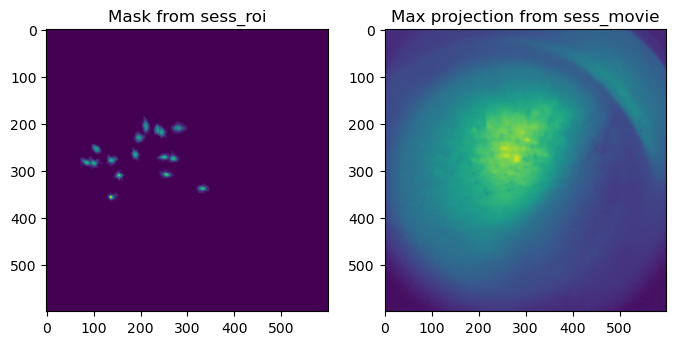

In [28]:
# load raw, non-motion corrected movie
images = tifffile.memmap(sess_movie)

# load cnmf object
cnmfe_model = load_CNMF(sess_roi)

# get mask
caiman_fpl = fpl_tools.play_caiman_movie(images=images, cnmf_object=cnmfe_model)

# take a peak
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(8,8))
ax[0].imshow(caiman_fpl.mask)
ax[0].set_title("Mask from sess_roi")
ax[1].imshow(np.max(images,axis=0))
ax[1].set_title("Max projection from sess_movie")

---

Use fastplotlib to determine if you have similar units across two separate recordings

In [29]:
mov = caiman_fpl.play_movie_draw_roi(components_type='accepted',cmap='gray',show_movie=False)
mov.show()

RFBOutputContext()

/Users/js0403/anaconda3/envs/caiman/lib/python3.11/site-packages/fastplotlib/graphics/_features/_base.py:34: UserWarning: converting float64 array to float32
  warn(f"converting {array.dtype} array to float32")


JupyterOutputContext(children=(JupyterWgpuCanvas(), IpywidgetToolBar(children=(Button(icon='expand-arrows-alt'…